# Multi-Layer Perceptron for Regression

In [1]:
import nbloader,os,warnings
warnings.filterwarnings("ignore") 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import tensorflow.contrib.slim as slim
from sklearn.utils import shuffle
from util import gpusession,create_gradient_clipping,data4reg,plot_1dRegData,print_n_txt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
if __name__ == "__main__":
    print ("TensorFlow version is [%s]."%(tf.__version__))

TensorFlow version is [1.4.1].


### Define MLP Class

In [2]:
class mlp_reg_class(object):
    def __init__(self,_name='MLP',_xdim=1,_ydim=1,_hdims=[64,64]
                 ,_actv=tf.nn.tanh,_bn=slim.batch_norm
                 ,_l2_reg_coef=1e-5,_GPU_ID=0,_VERBOSE=True):
        self.name = _name
        self.xdim = _xdim 
        self.ydim = _ydim
        self.hdims = _hdims
        self.actv = _actv
        self.bn = _bn
        self.l2_reg_coef = _l2_reg_coef
        self.GPU_ID = _GPU_ID
        self.VERBOSE = _VERBOSE
        with tf.device('/device:GPU:%d'%(self.GPU_ID)):
            # Build model
            self.build_model()
            # Build graph
            self.build_graph()
            # Check params
            self.check_params()
        
    def build_model(self):
        self.x = tf.placeholder(dtype=tf.float32,shape=[None,self.xdim]) # Input [N x xdim]
        self.y = tf.placeholder(dtype=tf.float32,shape=[None,self.ydim]) # Output [N x ydim]
        self.kp = tf.placeholder(dtype=tf.float32,shape=[]) # Keep probability 
        self.lr = tf.placeholder(dtype=tf.float32,shape=[]) # Learning rate
        self.is_training = tf.placeholder(dtype=tf.bool,shape=[]) # Training flag
        # Initializers
        self.fully_init  = tf.random_normal_initializer(stddev=0.01)
        self.bias_init   = tf.constant_initializer(0.)
        self.bn_init     = {'beta': tf.constant_initializer(0.),
                           'gamma': tf.random_normal_initializer(1., 0.01)}
        self.bn_params   = {'is_training':self.is_training,'decay':0.9,'epsilon':1e-5,
                           'param_initializers':self.bn_init,'updates_collections':None}
        # Build graph
        with tf.variable_scope(self.name,reuse=False) as scope:
            with slim.arg_scope([slim.fully_connected]
                                ,activation_fn=self.actv
                                ,weights_initializer=self.fully_init
                                ,biases_initializer=self.bias_init
                                ,normalizer_fn=self.bn,normalizer_params=self.bn_params
                                ,weights_regularizer=None):
                _net = self.x # Input [N x xdim]
                for h_idx in range(len(self.hdims)): # Loop over hidden layers
                    _hdim = self.hdims[h_idx]
                    _net = slim.fully_connected(_net,_hdim,scope='lin'+str(h_idx))
                    _net = slim.dropout(_net,keep_prob=self.kp,is_training=self.is_training
                                        ,scope='dr'+str(h_idx))  
                self.feat = _net # Feature [N x Q]
                self.out = slim.fully_connected(self.feat,self.ydim,activation_fn=None
                                                ,scope='out') # [N x D]
    def build_graph(self):
        # L2 fitting loss
        self._loss_fit = tf.reduce_sum(tf.pow(self.out-self.y,2),axis=1) # [N x 1]
        self.loss_fit = tf.reduce_mean(self._loss_fit) # [1]
        # Weight decay
        _g_vars = tf.trainable_variables()
        self.c_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        self.l2_reg = self.l2_reg_coef*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in self.c_vars])) # [1]
        self.loss_total = self.loss_fit + self.l2_reg # [1]
        # Optimizer
        USE_ADAM = False
        if USE_ADAM:
            self.optm = tf.train.AdamOptimizer(learning_rate=self.lr,beta1=0.9,beta2=0.999
                                               ,epsilon=1e-0).minimize(self.loss_total)
        else:
            self.optm = tf.train.MomentumOptimizer(learning_rate=self.lr
                                                   ,momentum=0.0).minimize(self.loss_total)
     # Check parameters
    def check_params(self):
        _g_vars = tf.global_variables()
        self.g_vars = [var for var in _g_vars if '%s/'%(self.name) in var.name]
        if self.VERBOSE:
            print ("==== Global Variables ====")
        for i in range(len(self.g_vars)):
            w_name  = self.g_vars[i].name
            w_shape = self.g_vars[i].get_shape().as_list()
            if self.VERBOSE:
                print (" [%02d] Name:[%s] Shape:[%s]" % (i,w_name,w_shape))
                
    # Sampler
    def sampler(self,_sess,_x):
        outVal = _sess.run(self.out,feed_dict={self.x:_x,self.kp:1.0,self.is_training:False})
        return outVal
    
    # Save 
    def save(self,_sess,_savename=None):
        """ Save name """
        if _savename==None:
            _savename='../net/net_%s.npz'%(self.name)
        """ Get global variables """
        self.g_wnames,self.g_wvals,self.g_wshapes = [],[],[]
        for i in range(len(self.g_vars)):
            curr_wname = self.g_vars[i].name
            curr_wvar  = [v for v in tf.global_variables() if v.name==curr_wname][0]
            curr_wval  = _sess.run(curr_wvar)
            curr_wval_sqz  = curr_wval.squeeze()
            self.g_wnames.append(curr_wname)
            self.g_wvals.append(curr_wval_sqz)
            self.g_wshapes.append(curr_wval.shape)
        """ Save """
        np.savez(_savename,g_wnames=self.g_wnames,g_wvals=self.g_wvals,g_wshapes=self.g_wshapes)
        if self.VERBOSE:
            print ("[%s] Saved. Size is [%.4f]MB" % 
                   (_savename,os.path.getsize(_savename)/1000./1000.))
            
    # Save 
    def save_final(self,_sess,_savename=None):
        """ Save name """
        if _savename==None:
            _savename='../net/net_%s_final.npz'%(self.name)
        """ Get global variables """
        self.g_wnames,self.g_wvals,self.g_wshapes = [],[],[]
        for i in range(len(self.g_vars)):
            curr_wname = self.g_vars[i].name
            curr_wvar  = [v for v in tf.global_variables() if v.name==curr_wname][0]
            curr_wval  = _sess.run(curr_wvar)
            curr_wval_sqz  = curr_wval.squeeze()
            self.g_wnames.append(curr_wname)
            self.g_wvals.append(curr_wval_sqz)
            self.g_wshapes.append(curr_wval.shape)
        """ Save """
        np.savez(_savename,g_wnames=self.g_wnames,g_wvals=self.g_wvals,g_wshapes=self.g_wshapes)
        print ("[%s] Saved. Size is [%.4f]MB" % 
               (_savename,os.path.getsize(_savename)/1000./1000.))
    
    # Restore
    def restore(self,_sess,_loadname=None):
        if _loadname==None:
            _loadname='../net/net_%s_final.npz'%(self.name)
        l = np.load(_loadname)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        for widx,wname in enumerate(g_wnames):
            curr_wvar  = [v for v in tf.global_variables() if v.name==wname][0]
            _sess.run(tf.assign(curr_wvar,g_wvals[widx].reshape(g_wshapes[widx])))
        if self.VERBOSE:
            print ("Weight restored from [%s] Size is [%.4f]MB" % 
                   (_loadname,os.path.getsize(_loadname)/1000./1000.))
    
    # Save to mat file
    def save2mat(self,_xdata='',_ydata='',_yref=''):
        # Save weights to mat file so that MATLAB can use it.
        npzPath = '../net/net_%s.npz'%(self.name)
        l = np.load(npzPath)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        D = {}
        for widx,wname in enumerate(g_wnames):
            cName = wname.replace(':0','')
            cName = cName.replace(self.name+'/','')
            cName = cName.replace('/','_')
            cVal = g_wvals[widx].reshape(g_wshapes[widx])
            D[cName] = cVal
            # if self.VERBOSE: print ("name is [%s] shape is %s."%(cName,cVal.shape,))
        # Save data
        if _xdata!='': D['xdata']=_xdata
        if _ydata!='': D['ydata']=_ydata
        if _yref!='': D['yref']=_yref
        # Save dictionary D to the mat file
        matPath = '../data/net_%s.mat'%(self.name)
        sio.savemat(matPath,D)
        if self.VERBOSE: print ("[%s] saved."%(matPath))
        
    # Save to mat file
    def save2mat_final(self,_xdata='',_ydata='',_yref=''):
        # Save weights to mat file so that MATLAB can use it.
        npzPath = '../net/net_%s_final.npz'%(self.name)
        l = np.load(npzPath)
        g_wnames = l['g_wnames']
        g_wvals  = l['g_wvals']
        g_wshapes = l['g_wshapes']
        D = {}
        for widx,wname in enumerate(g_wnames):
            cName = wname.replace(':0','')
            cName = cName.replace(self.name+'/','')
            cName = cName.replace('/','_')
            cVal = g_wvals[widx].reshape(g_wshapes[widx])
            D[cName] = cVal
            if self.VERBOSE:
                print ("name is [%s] shape is %s."%(cName,cVal.shape,))
        # Save data
        if _xdata!='': D['xdata']=_xdata
        if _ydata!='': D['ydata']=_ydata
        if _yref!='': D['yref']=_yref
        # Save dictionary D to the mat file        
        matPath = '../data/net_%s_final.mat'%(self.name)
        sio.savemat(matPath,D)
        print ("[%s] Saved. Size is [%.4f]MB" % 
               (matPath,os.path.getsize(matPath)/1000./1000.))
        
    # Train
    def train(self,_sess,_x,_y,_yref='',_lr=1e-3,_batchSize=512,_maxEpoch=1e4,_kp=1.0
              ,_LR_SCHEDULE=True
              ,_PRINT_EVERY=20,_PLOT_EVERY=20
              ,_SAVE_TXT=True,_SAVE_BEST_NET=True,_SAVE_FINAL=True):
        # Reference training data 
        _x_train,_y_train = _x,_y
        
        # Iterate
        if _PRINT_EVERY == 0: print_period = 0
        else: print_period = _maxEpoch//_PRINT_EVERY
        if _PLOT_EVERY == 0: plot_period = 0
        else: plot_period = _maxEpoch//_PLOT_EVERY
        
        maxIter = max(_x_train.shape[0]//_batchSize, 1)
        bestLossVal = np.inf
        if _SAVE_TXT:
            txtName = ('../res/res_%s.txt'%(self.name));f = open(txtName,'w') # Open txt file
            print_n_txt(_f=f,_chars='Text name: '+txtName,_DO_PRINT=True)
        for epoch in range((int)(_maxEpoch)+1): # For every epoch
            _x_train,_y_train = shuffle(_x_train,_y_train)
            for iter in range(maxIter): # For every iteration
                start,end = iter*_batchSize,(iter+1)*_batchSize
                if _LR_SCHEDULE:
                    if epoch < 0.5*_maxEpoch:
                        lr_use = _lr
                    elif epoch < 0.75*_maxEpoch:
                        lr_use = _lr/5.
                    else:
                        lr_use = _lr/10.
                else:
                    lr_use = _lr
                feeds = {self.x:_x_train[start:end,:],self.y:_y_train[start:end,:]
                         ,self.kp:_kp,self.lr:lr_use,self.is_training:True}
                # Optimize 
                _sess.run(self.optm,feeds)

            # Track the Best result
            BEST_FLAG = False
            check_period = _maxEpoch//100
            if (epoch%check_period)==0:
                # Feed total dataset 
                feeds = {self.x:_x,self.y:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.loss_fit,self.l2_reg]
                lossVal,loss_fit,l2_reg = _sess.run(opers,feeds)
                if (lossVal < bestLossVal) & (epoch >= 3):
                    bestLossVal = lossVal
                    BEST_FLAG = True
                    if _SAVE_BEST_NET:
                        self.save(_sess) # Save the current best model 
                        self.save2mat(_xdata=_x,_ydata=_y,_yref=_yref)
            
            # Print current result 
            if (print_period!=0) and ((epoch%print_period)==0 or (epoch==(_maxEpoch-1))): # Print 
                feeds = {self.x:_x,self.y:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.loss_fit,self.l2_reg]
                lossVal,loss_fit,l2_reg = _sess.run(opers,feeds)
                if _SAVE_TXT:
                    strTemp = ("[%d/%d] loss:%.3f(fit:%.3f+l2:%.3f) bestLoss:%.3f"
                               %(epoch,_maxEpoch,lossVal,loss_fit,l2_reg,bestLossVal))
                    print_n_txt(_f=f,_chars=strTemp,_DO_PRINT=self.VERBOSE)
                else:
                    if self.VERBOSE:
                        print ("[%d/%d] loss:%.3f(fit:%.3f+l2:%.3f) bestLoss:%.3f"
                                   %(epoch,_maxEpoch,lossVal,loss_fit,l2_reg,bestLossVal))

            # Plot current result 
            if (plot_period!=0) and ((epoch%plot_period)==0 or (epoch==(_maxEpoch-1))): # Plot
                # Get loss vals
                feeds = {self.x:_x,self.y:_y,self.kp:1.0,self.is_training:False}
                opers = [self.loss_total,self.loss_fit,self.l2_reg]
                lossVal,loss_fit,l2_reg = _sess.run(opers,feeds)
                # Output
                ytest = self.sampler(_sess=_sess,_x=_x)
                # Plot first dimensions of both input and output
                x_plot,y_plot = _x[:,0],_y[:,0] # Traning data 
                plt.figure(figsize=(8,4));
                plt.axis([np.min(x_plot),np.max(x_plot),np.min(y_plot)-0.1,np.max(y_plot)+0.1])
                if _yref != '': plt.plot(x_plot,_yref[:,0],'r.') # Plot reference
                plt.plot(x_plot,y_plot,'k.') # Plot training data
                plt.plot(_x,ytest[:,0],'b.')
                plt.title("[%d/%d] name:[%s] lossVal:[%.3e]"%(epoch,_maxEpoch,self.name,lossVal)); 
                plt.show()
        # Save final weights 
        if _SAVE_FINAL:
            self.save_final(_sess)
            self.save2mat_final(_xdata=_x,_ydata=_y,_yref=_yref)
        
    # Test
    def test(self,_sess,_xdata,_ydata,_yref,_xtest,_titleStr
             ,_PLOT_TRAIN=True,_PLOT_RES=True,_SAVE_FIG=False):
        ytest = self.sampler(_sess=_sess,_x=_xtest)
        # Plot 
        if _PLOT_TRAIN:
            plt.figure(figsize=(6,4))
            plt.axis([np.min(_xdata),np.max(_xdata),np.min(_ydata),np.max(_ydata)])
            plt.plot(_xdata,_ydata,'k.')
            plt.xlabel('Input',fontsize=13);plt.ylabel('Output',fontsize=13)
            plt.title('Training Data for a Regression Task',fontsize=16); 
            if _SAVE_FIG: 
                plt.savefig('../fig/fig_%s_data.png'%(self.name)); plt.show()
            else: 
                plt.show()
        # Plot 
        if _PLOT_RES:
            fig = plt.figure(figsize=(6,4))
            plt.axis([np.min(_xdata),np.max(_xdata),np.min(_ydata),np.max(_ydata)])
            ht,=plt.plot(_xdata,_yref,'r-',linewidth=2)
            hd,=plt.plot(_xdata,_ydata,'k.')
            hf,=plt.plot(_xtest,ytest[:,0:1],'b-',linewidth=2)
            plt.xlabel('Input',fontsize=13);plt.ylabel('Output',fontsize=13)
            plt.title('%s'%(_titleStr),fontsize=18)
            plt.legend([ht,hd,hf],['Target function','Training data','Fitting result']
                       ,fontsize=15,loc='upper right')
            if _SAVE_FIG: 
                plt.savefig('../fig/fig_%s_res.png'%(self.name)); plt.show()
            else: 
                plt.show()
if __name__ == "__main__":
    print ("mlp_reg_class defined.")

mlp_reg_class defined.


### Train MLP for Regression

==== Global Variables ====
 [00] Name:[MLP_cosexp_oRate00_var1.0e-06/lin0/weights:0] Shape:[[1, 128]]
 [01] Name:[MLP_cosexp_oRate00_var1.0e-06/lin0/biases:0] Shape:[[128]]
 [02] Name:[MLP_cosexp_oRate00_var1.0e-06/lin1/weights:0] Shape:[[128, 128]]
 [03] Name:[MLP_cosexp_oRate00_var1.0e-06/lin1/biases:0] Shape:[[128]]
 [04] Name:[MLP_cosexp_oRate00_var1.0e-06/out/weights:0] Shape:[[128, 1]]
 [05] Name:[MLP_cosexp_oRate00_var1.0e-06/out/biases:0] Shape:[[1]]
 [06] Name:[MLP_cosexp_oRate00_var1.0e-06/lin0/weights/Momentum:0] Shape:[[1, 128]]
 [07] Name:[MLP_cosexp_oRate00_var1.0e-06/lin0/biases/Momentum:0] Shape:[[128]]
 [08] Name:[MLP_cosexp_oRate00_var1.0e-06/lin1/weights/Momentum:0] Shape:[[128, 128]]
 [09] Name:[MLP_cosexp_oRate00_var1.0e-06/lin1/biases/Momentum:0] Shape:[[128]]
 [10] Name:[MLP_cosexp_oRate00_var1.0e-06/out/weights/Momentum:0] Shape:[[128, 1]]
 [11] Name:[MLP_cosexp_oRate00_var1.0e-06/out/biases/Momentum:0] Shape:[[1]]
[0/10000] loss:0.203(fit:0.203+l2:0.000) bestLo

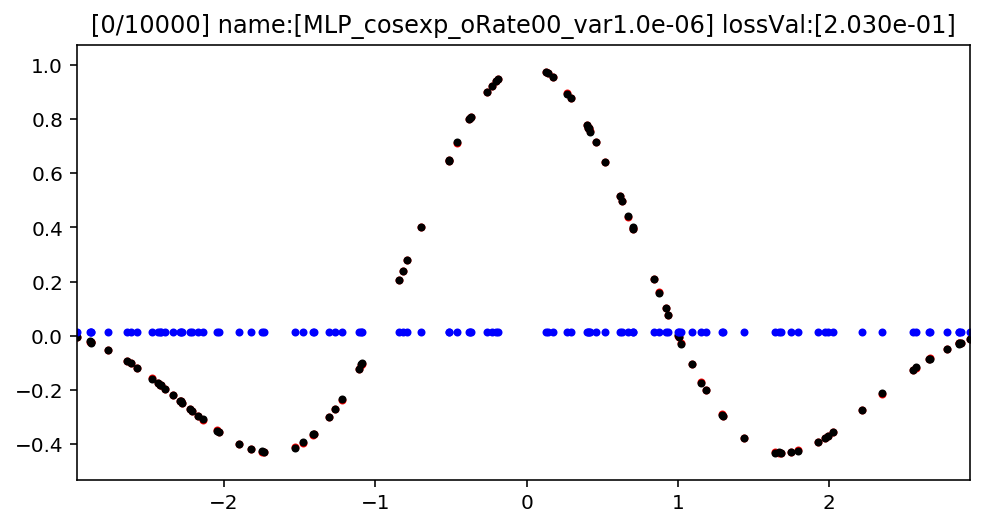

[500/10000] loss:0.069(fit:0.069+l2:0.000) bestLoss:0.069


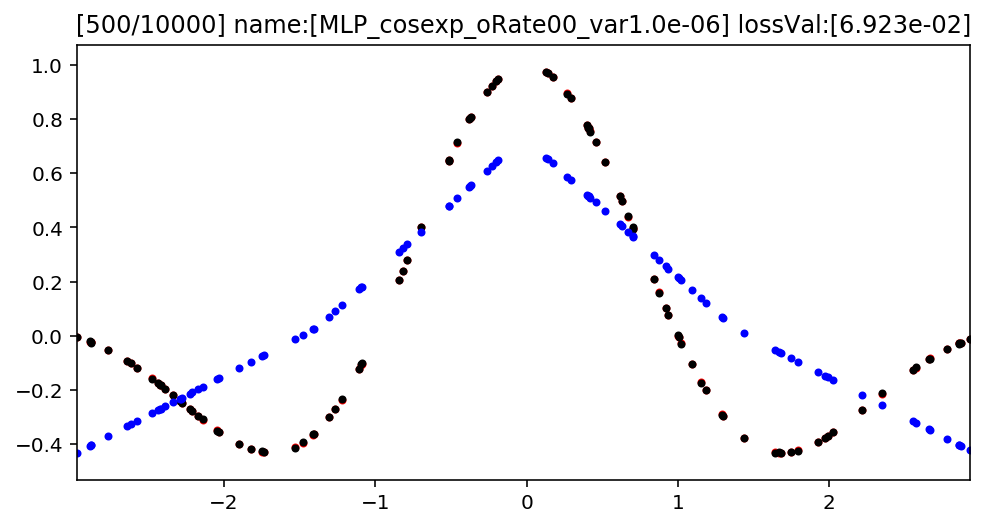

[1000/10000] loss:0.012(fit:0.012+l2:0.000) bestLoss:0.012


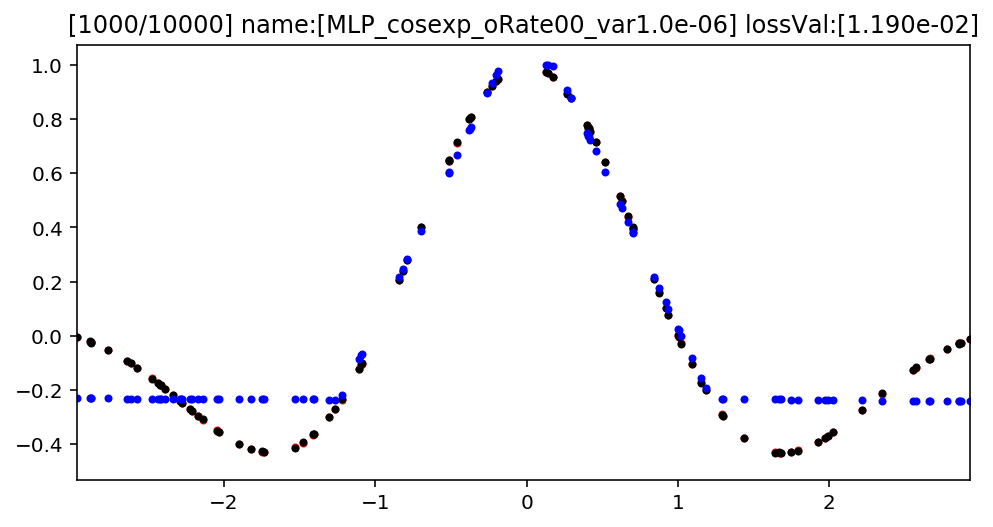

[1500/10000] loss:0.002(fit:0.002+l2:0.000) bestLoss:0.002


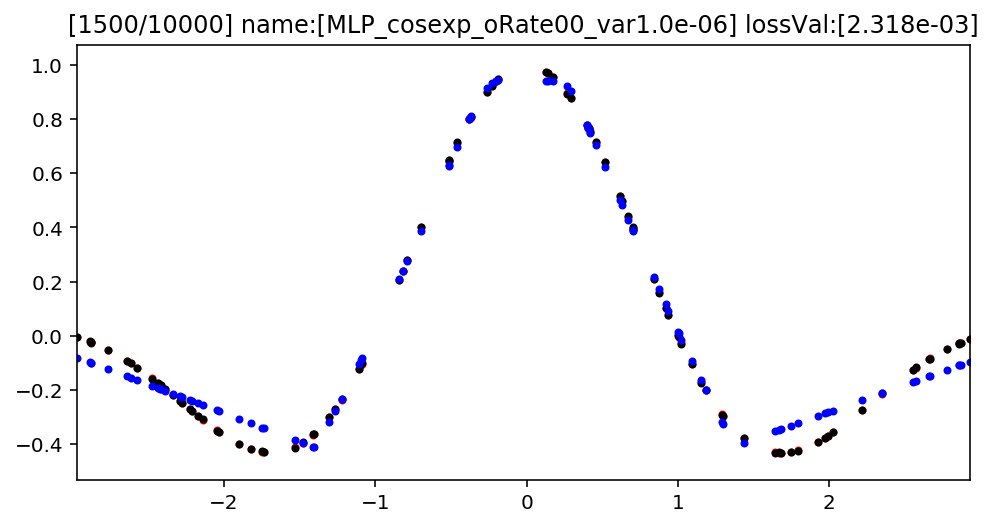

[2000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


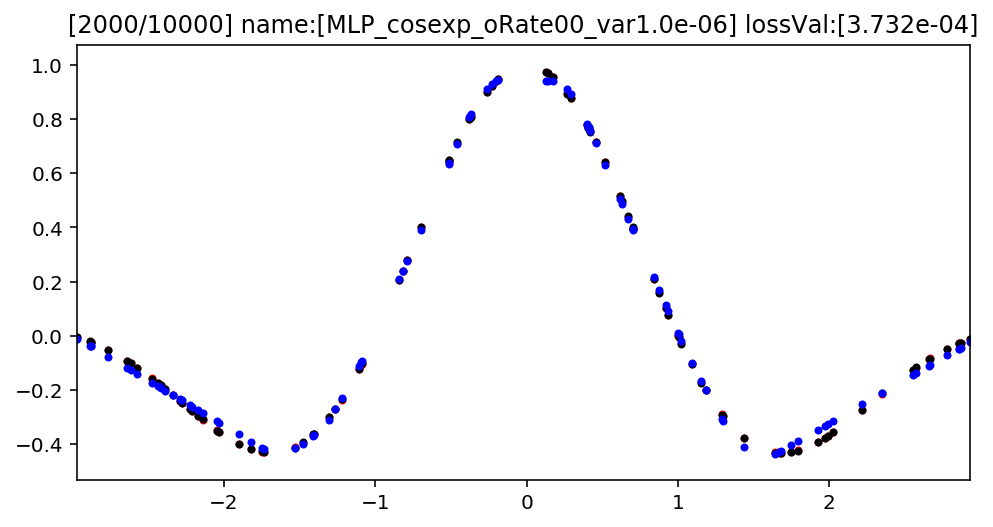

[2500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


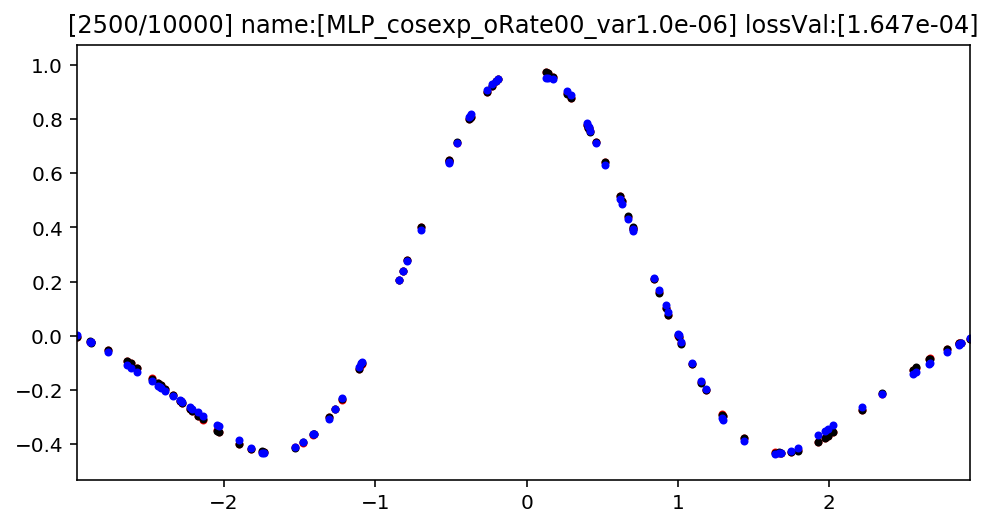

[3000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


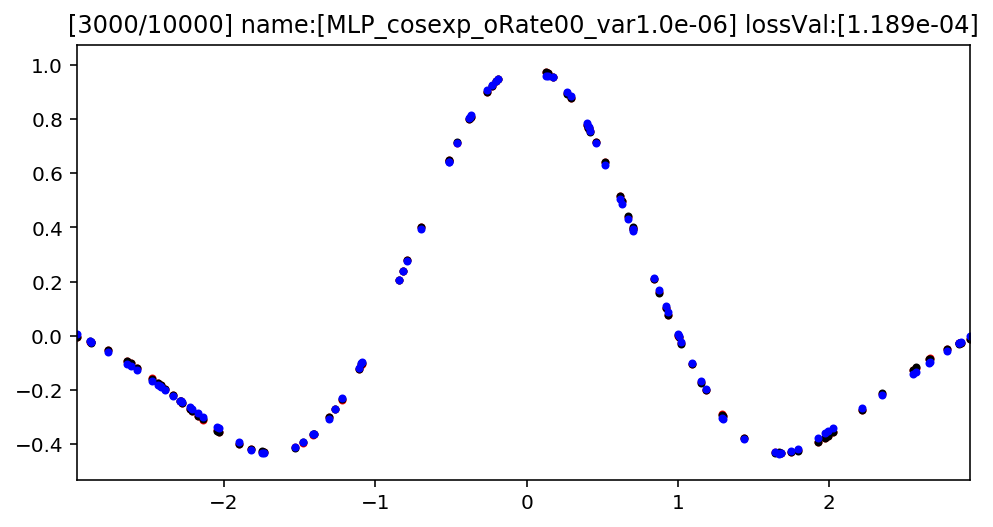

[3500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


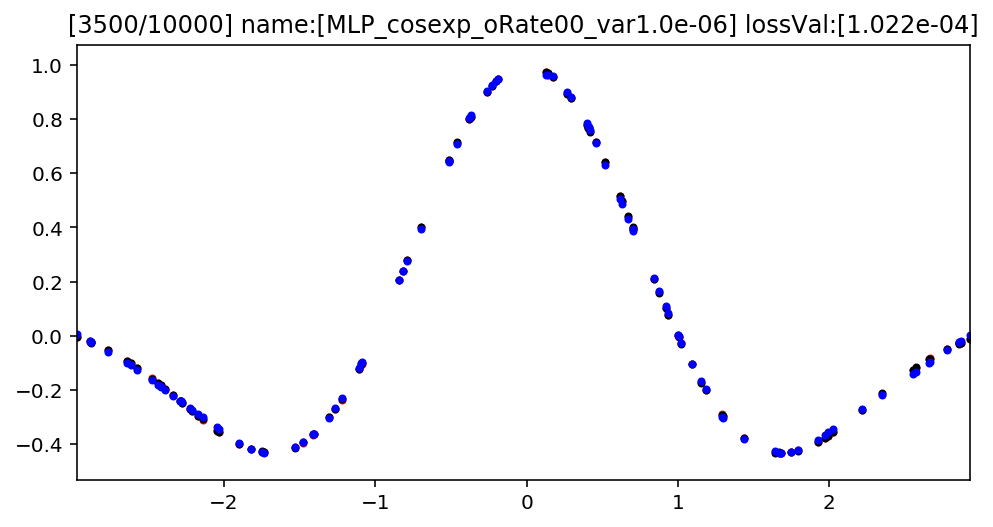

[4000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


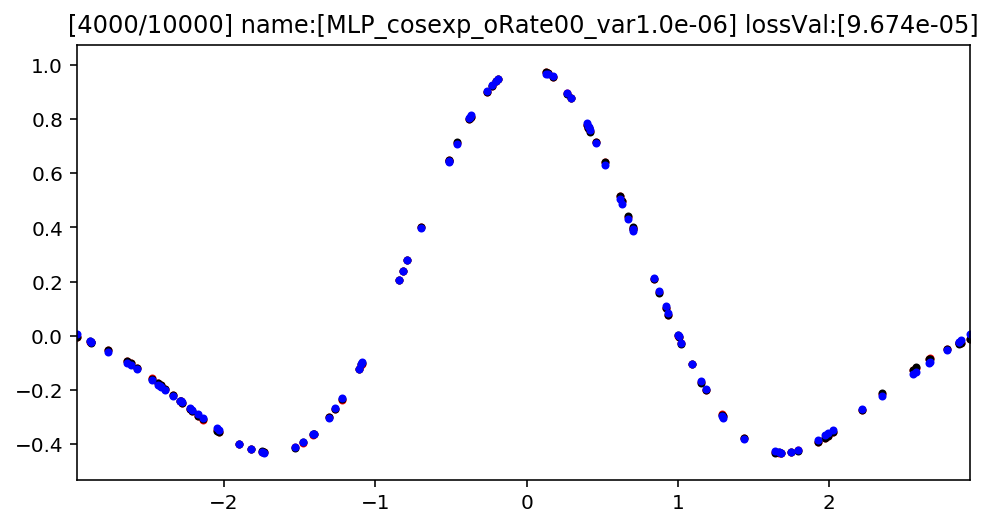

[4500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


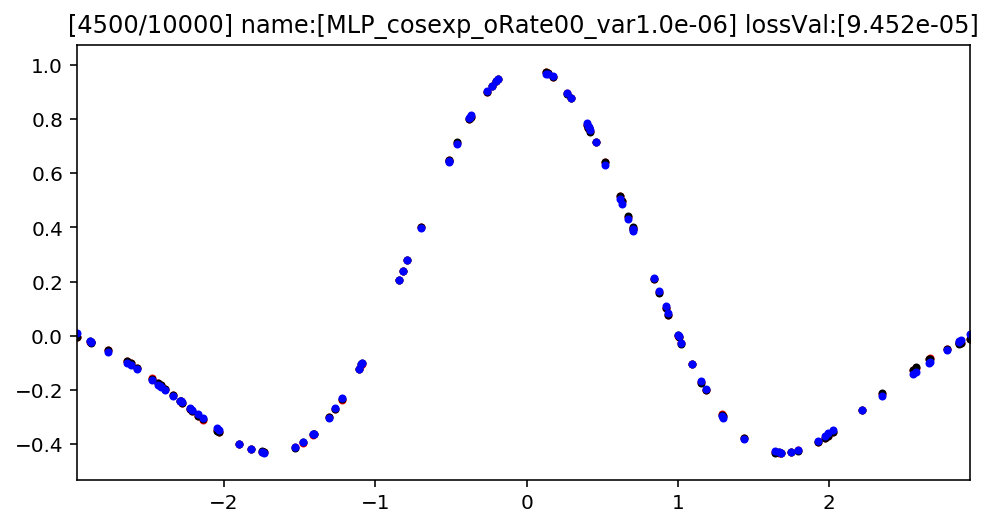

[5000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


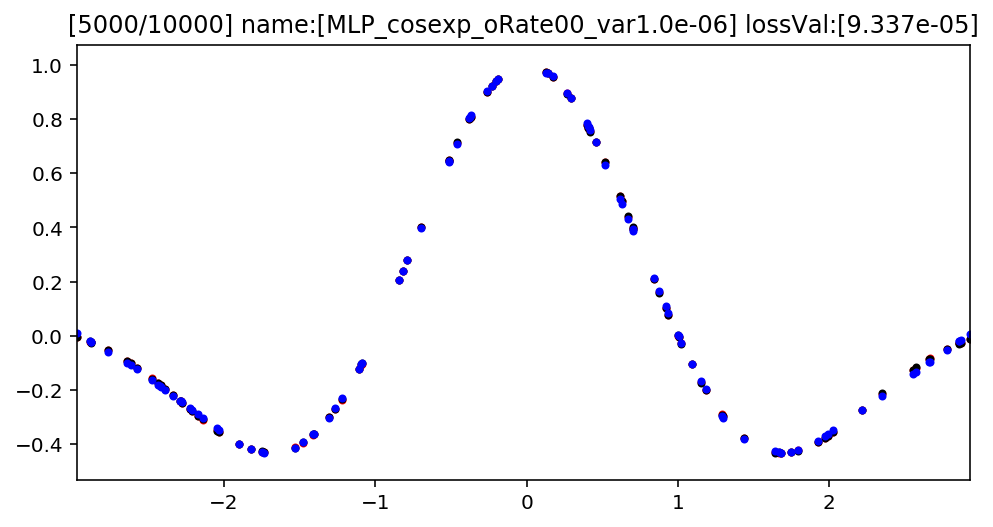

[5500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


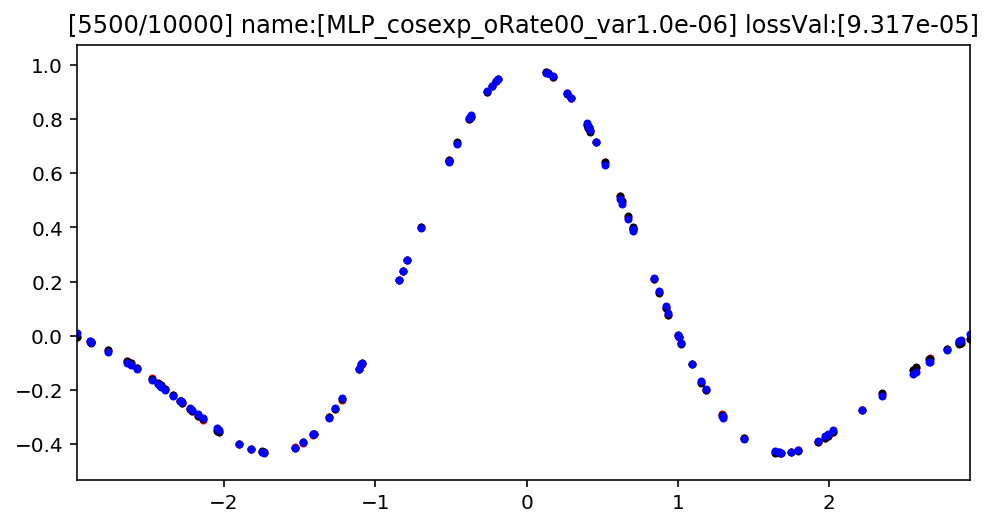

[6000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


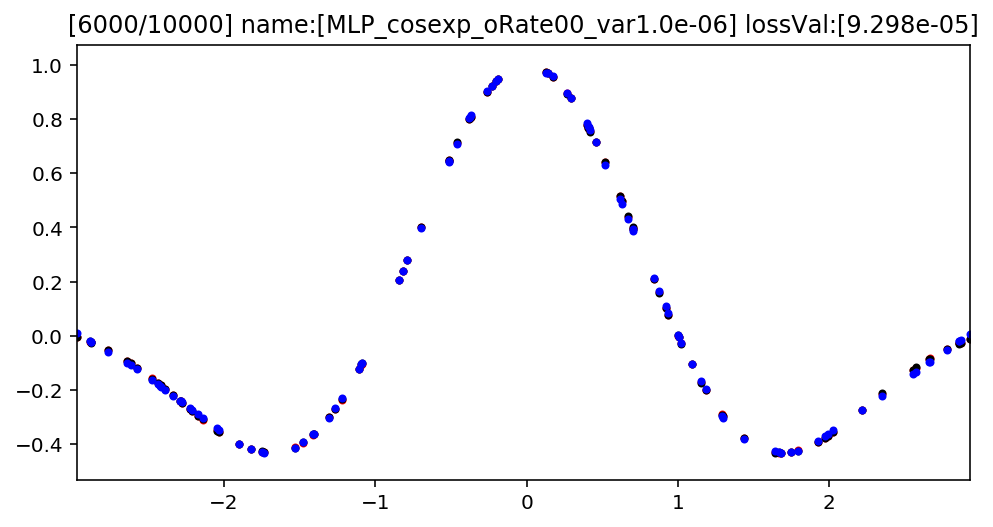

[6500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


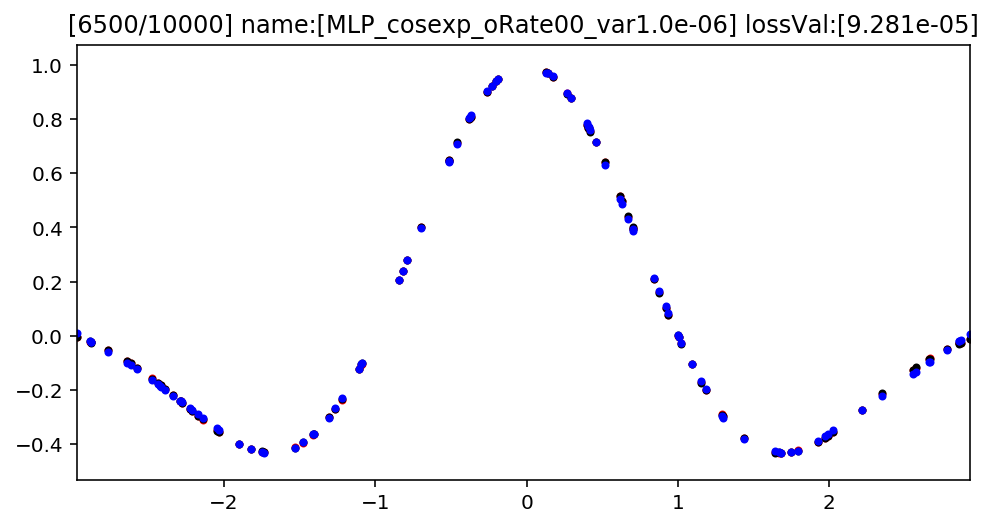

[7000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


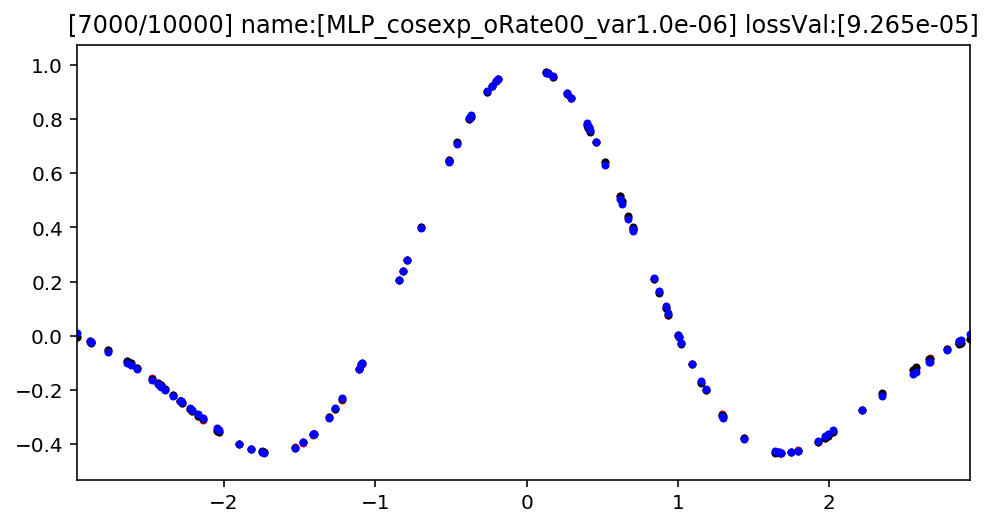

[7500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


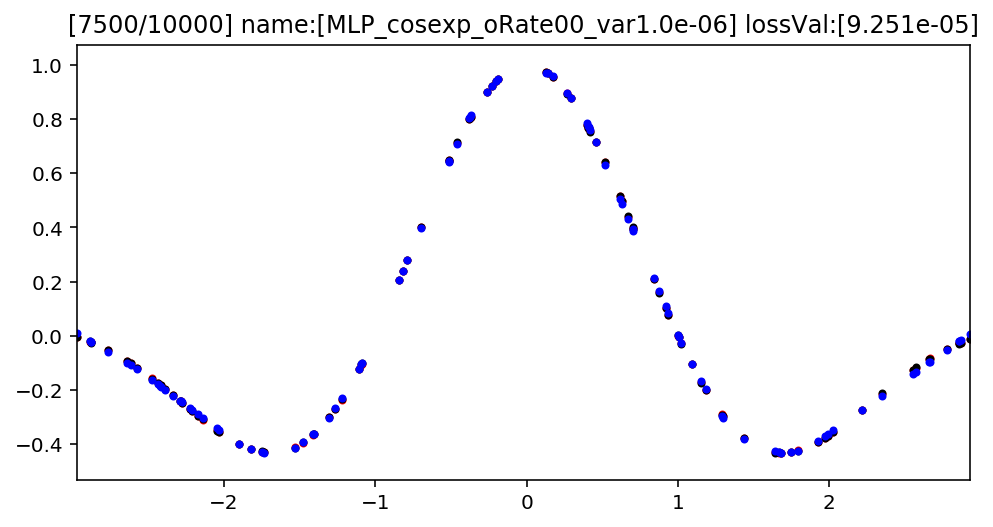

[8000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


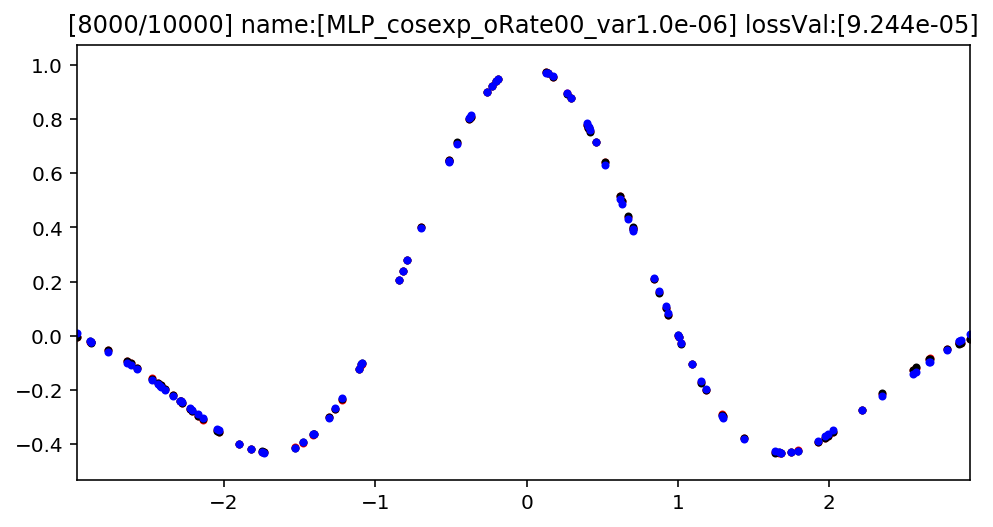

[8500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


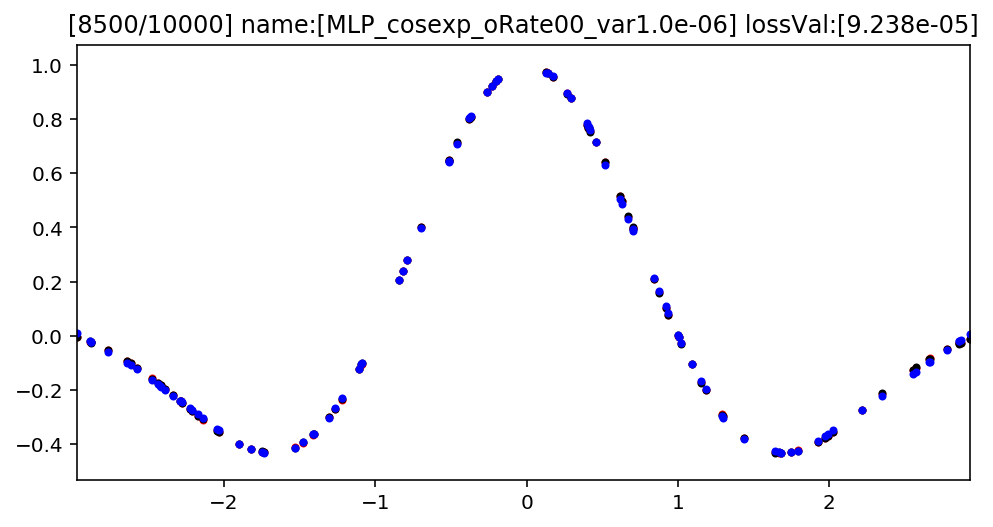

[9000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


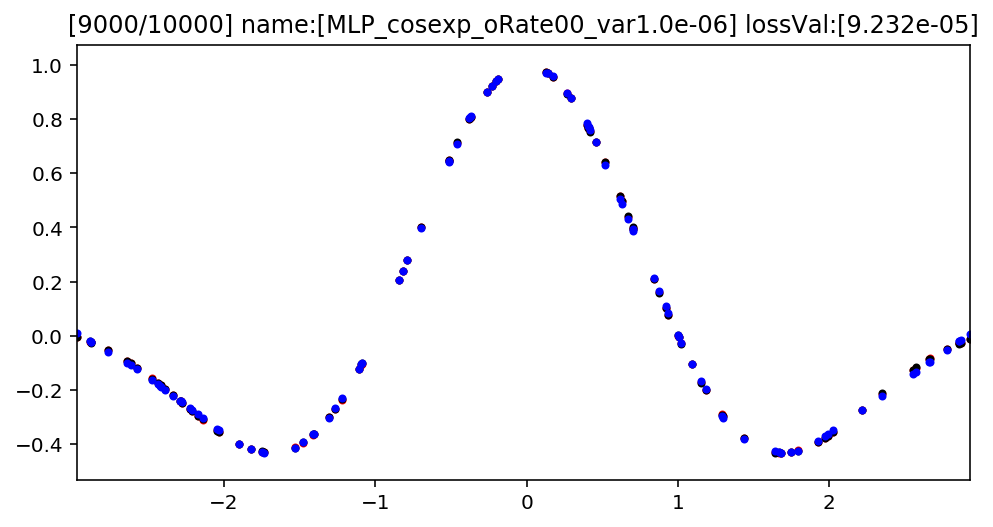

[9500/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


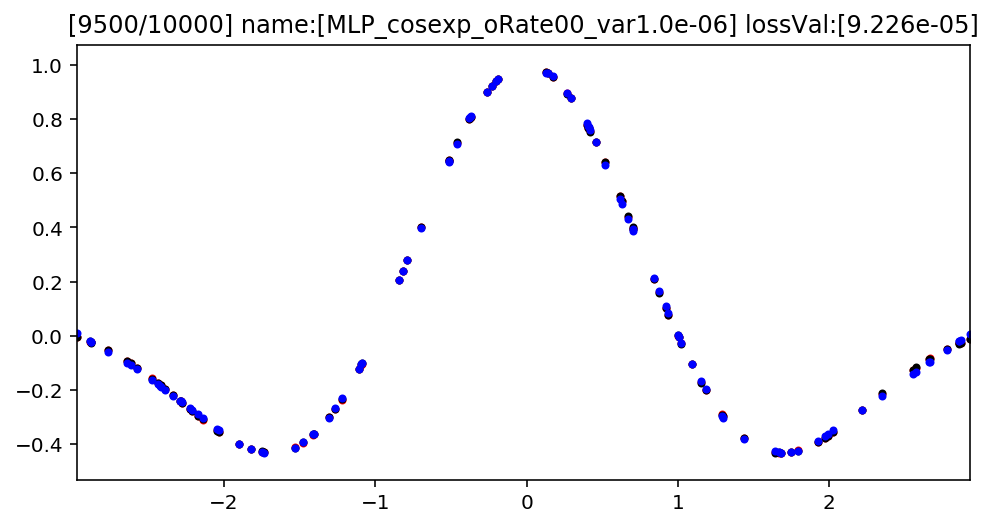

[9999/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


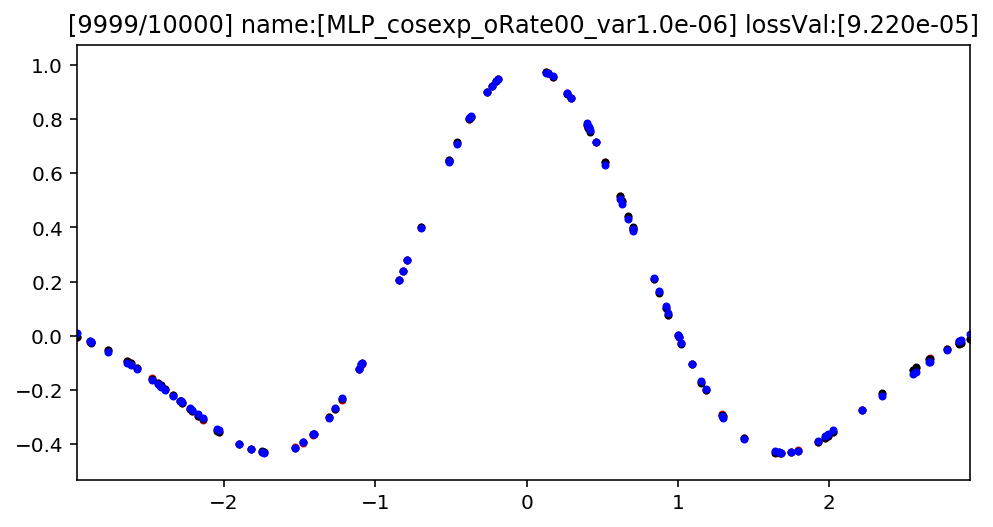

[10000/10000] loss:0.000(fit:0.000+l2:0.000) bestLoss:0.000


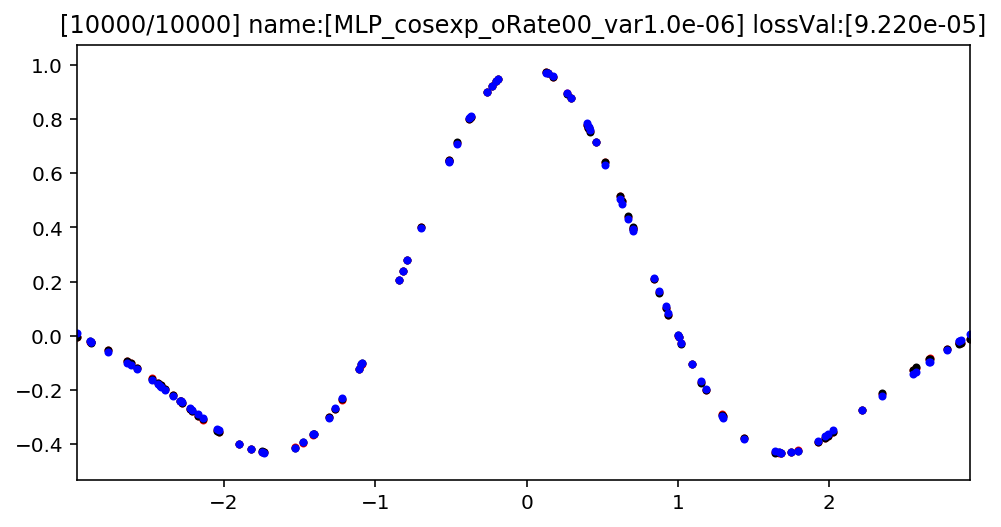

[../net/net_MLP_cosexp_oRate00_var1.0e-06_final.npz] Saved. Size is [0.2081]MB
name is [lin0_weights] shape is (1, 128).
name is [lin0_biases] shape is (128,).
name is [lin1_weights] shape is (128, 128).
name is [lin1_biases] shape is (128,).
name is [out_weights] shape is (128, 1).
name is [out_biases] shape is (1,).
name is [lin0_weights_Momentum] shape is (1, 128).
name is [lin0_biases_Momentum] shape is (128,).
name is [lin1_weights_Momentum] shape is (128, 128).
name is [lin1_biases_Momentum] shape is (128,).
name is [out_weights_Momentum] shape is (128, 1).
name is [out_biases_Momentum] shape is (1,).
[../data/net_MLP_cosexp_oRate00_var1.0e-06_final.mat] Saved. Size is [0.1380]MB
Train done.


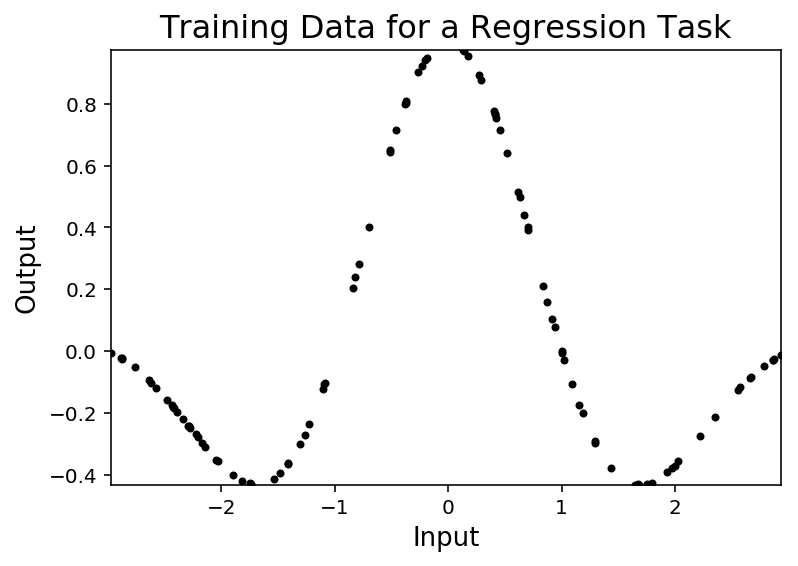

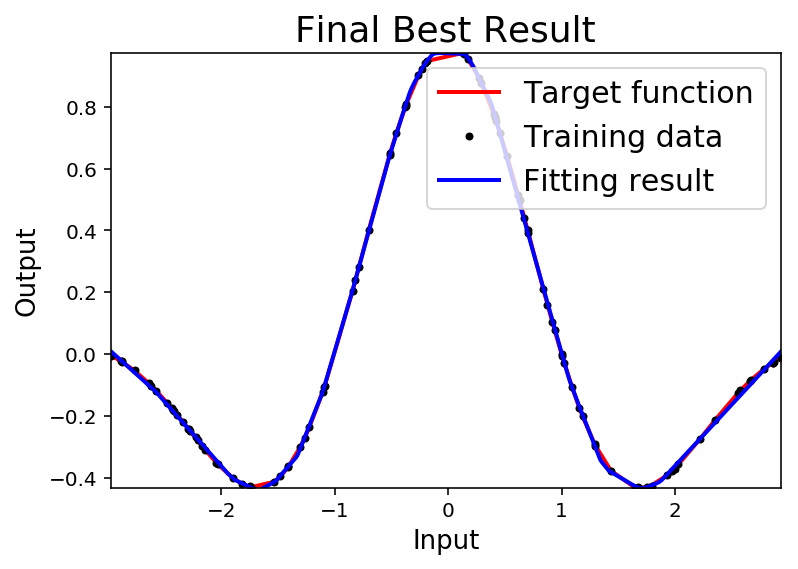

In [6]:
if __name__ == "__main__":
    # Training data
    dataType = 'cosexp' # ['cosexp','linear','step']
    oRate = 0.0
    measVar = 1e-6
    x,y,t=data4reg(_type=dataType,_n=100,_oRange=[-1.5,+2.5],_oRate=oRate,measVar=measVar)
    xtest = np.linspace(start=-3,stop=3,num=500).reshape((-1,1))
    # plot_1dRegData(_x=x,_y=y,_t=t,_type='Training data [%s] function'%(dataType),_figSize=(8,4))
    
    # Make graph
    tf.reset_default_graph(); sess = gpusession()
    tf.set_random_seed(0); np.random.seed(0)
    MLP =  mlp_reg_class(_name='MLP_%s_oRate%02d_var%.1e'%(dataType,oRate*100,measVar)
                         ,_xdim=1,_ydim=1,_hdims=[128,128],_actv=tf.nn.relu,_bn=None#slim.batch_norm
                         ,_l2_reg_coef=1e-5,_VERBOSE=True)
    sess.run(tf.global_variables_initializer()) # Initialize variables
    
    # Train 
    DO_TRAIN = True
    if DO_TRAIN:
        MLP.train(_sess=sess,_x=x,_y=y,_yref=t 
               ,_lr=1e-1,_batchSize=256,_maxEpoch=1e4,_kp=1.0
               ,_LR_SCHEDULE=True
               ,_PRINT_EVERY=20,_PLOT_EVERY=20
               ,_SAVE_TXT=False,_SAVE_BEST_NET=False)
        print ("Train done.") 
    else: 
        MLP.restore(sess)
        print ("Network restored.")
        
    # Test 
    MLP.test(_sess=sess,_xdata=x,_ydata=y,_yref=t,_xtest=xtest
           ,_titleStr='Final Best Result'
           ,_PLOT_TRAIN=True,_PLOT_RES=True,_SAVE_FIG=False)
    